In [126]:
#Import libraries
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from web3 import Web3
from tqdm import tqdm
from dotenv import load_dotenv
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [83]:
# Load .env file
load_dotenv()

# Load API key from .env file
api_key = os.getenv("ALCHEMY_API_KEY")

### Step 1: Set Up Web3 Connection

In [84]:
# Define the Alchemy API endpoint
api_endpoint = f"https://eth-mainnet.alchemyapi.io/v2/{api_key}"

# Set up Web3 connection
w3 = Web3(Web3.HTTPProvider(api_endpoint))

# Check if the connection is successful
if w3.isConnected():
    print("Connected to Ethereum node.")
else:
    print("Connection failed!")

Connected to Ethereum node.


In [86]:
# Define the start and end dates for which the data is required
start_date = datetime(2022, 5, 19)
end_date = datetime(2023, 5, 19)

# Step 2: Estimate the number of blocks per hour and total blocks for the time period

In [87]:
# Alternative to calculate average block time
# Get the number of the latest block
# latest_block_number = w3.eth.get_block('latest')['number']
# # Calculate the block times of the latest 1000 blocks
# block_times = []
# for i in range(1000):
#     # Get the current and previous blocks
#     current_block = w3.eth.get_block(latest_block_number - i)
#     previous_block = w3.eth.get_block(latest_block_number - i - 1)
    
#     # Calculate the block time and append to the list
#     block_time = current_block['timestamp'] - previous_block['timestamp']
#     block_times.append(block_time)

# # Calculate the average block time
# average_block_time = sum(block_times) / len(block_times)
# print(f"Average block time: {average_block_time} seconds")

# Define the block time(in seconds)
avg_block_time = 13  
print(f"Average block time: {avg_block_time} seconds")

# Calculate the estimated number of blocks per hourn(3600 seconds in an hour)
blocks_per_hour = int(3600 / avg_block_time)
print(f"Estimated blocks per hour: {blocks_per_hour}")

# Calculate the total hours for the given time period
total_hours = int((end_date - start_date).total_seconds() / 3600)

# Calculate the total number of blocks for the given time period
total_blocks = total_hours * blocks_per_hour
print(f"Total number of hourly blocks for the given time period: {total_blocks}")

Average block time: 13 seconds
Estimated blocks per hour: 276
Total number of hourly blocks for the given time period: 2417760


### Step 3: Fetch the gas prices and save them in a pandas DataFrame
In this step, we iterate through all the blocks within our determined range, fetch the block details, and extract the gas prices and timestamps. The gas price, initially in hexadecimal format ('baseFeePerGas'), is converted into an integer using `int(block['baseFeePerGas'], 16)`. For each block, a new DataFrame is created to store the gas price and timestamp. We use `pandas.concat()` to combine these new DataFrames with our main `gas_price_data` DataFrame.

The base fee per gas is typically represented as a hexadecimal number in the block information, so it is being converted to an integer using the int() function with base 16.
The gas prices obtained are in "wei", which is the smallest denomination of ether.

For perspective:
1 Ether (ETH) = 1,000,000,000,000,000,000 Wei (1e18 Wei)

In [88]:
# Get the latest block number
latest_block = w3.eth.block_number

In [89]:
# Calculate the start block
start_block = latest_block - total_blocks
start_block

14886220

In [90]:
# Initialize an empty DataFrame to store the gas prices
gas_price_data = pd.DataFrame(columns=['timestamp', 'gas_price'])

# Loop through the blocks, show status bar
for block_number in tqdm(range(start_block, latest_block, blocks_per_hour),
                         desc="Fetching gas prices data"): 
    
    # Get the block details
    block = w3.eth.get_block(block_number)

    # Convert the gas price from hex to integer
    gas_price = int(block['baseFeePerGas'], 16)

    # Convert timestamp to datetime and create a DataFrame with the block timestamp and gas price
    block_data = pd.DataFrame({
        'timestamp': [datetime.fromtimestamp(block['timestamp'])],
        'gas_price': [gas_price]
    })

    # Append the block data to the gas price data DataFrame
    gas_price_data = pd.concat([gas_price_data, block_data])

Fetching gas prices data: 100%|█████████████| 8760/8760 [19:40<00:00,  7.42it/s]


In [91]:
# Save the DataFrame to a CSV file
gas_price_data.to_csv('resources/gas_price_data.csv', index=False)

In [99]:
gas_price_data.head()

,gas_price
timestamp,
2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,67510279000


In [113]:
# Set `timestamp` column as index, copy DataFrame
gas_price_df = gas_price_data.set_index('timestamp').copy()

TypeError: set_index() got an unexpected keyword argument 'parse_dates'

In [124]:
gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-06-01 11:03:52 to 2023-05-20 15:50:35
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   gas_price  8760 non-null   object
dtypes: object(1)
memory usage: 136.9+ KB


In [107]:
display(gas_price_df.head(40))
gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,67510279000
2022-06-01 16:15:23,32404767035
2022-06-01 17:18:36,31681542751
2022-06-01 18:28:45,63240093401
2022-06-01 19:33:58,41244724759


,gas_price
timestamp,
2023-05-20 07:26:23,36167651916
2023-05-20 08:22:11,42579332023
2023-05-20 09:17:47,36887580795
2023-05-20 10:13:23,42755192159
2023-05-20 11:09:35,34687802687
2023-05-20 12:05:35,29684795277
2023-05-20 13:02:35,31417792342
2023-05-20 13:58:35,31031853696
2023-05-20 14:54:23,28188597658


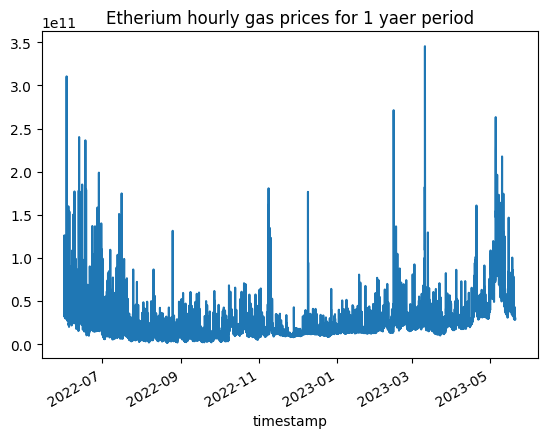

In [117]:
gas_price_df['gas_price'].plot(
    title="Etherium hourly gas prices for 1 yaer period");

### Step 4:Resample to daily data
The format 6.007497e+10 is scientific notation, and it is equivalent to 60,074,970,000. Scientific notation is often used for very large or very small numbers to make them easier to read and write.

In [123]:
# Resample the data into daily data, taking the mean gas price for each day
daily_gas_price_df = gas_price_df.resample('D').mean()
daily_gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-06-01 to 2023-05-20
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_price  354 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [116]:
display(daily_gas_price_df.head(20))
daily_gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01,6.007497e+10
2022-06-02,5.982783e+10
2022-06-03,6.758136e+10
2022-06-04,5.059850e+10
2022-06-05,5.107946e+10
2022-06-06,4.686028e+10
2022-06-07,5.828740e+10
2022-06-08,6.450062e+10
2022-06-09,5.889821e+10


,gas_price
timestamp,
2023-05-11,9.650878e+10
2023-05-12,5.662023e+10
2023-05-13,3.934500e+10
2023-05-14,4.242398e+10
2023-05-15,6.041061e+10
2023-05-16,5.258804e+10
2023-05-17,5.147708e+10
2023-05-18,5.086370e+10
2023-05-19,4.182389e+10


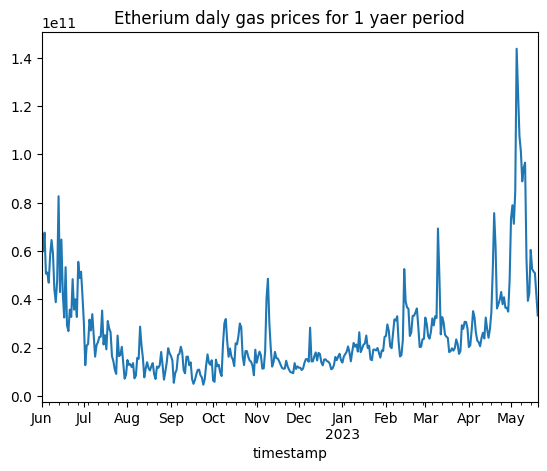

In [118]:
daily_gas_price_df['gas_price'].plot(
    title="Etherium daly gas prices for 1 yaer period");

### Step 6: Check for Stationarity
Before applying an ARIMA model, we need to make sure our data is stationary. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
This function will print out the test statistic, p-value, and critical values for the test. If the test statistic is less than the critical value, we can reject the null hypothesis (that the time series is not stationary). If not, we will need to transform the data to make it stationary.

In [125]:
adf_test = adfuller(daily_gas_price_df['gas_price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.012721271931087587


In [121]:
# Define a function to perform the Augmented Dickey-Fuller test
def check_stationarity(data):
    """
    Perform Augmented Dickey-Fuller test to check for stationarity.
    
    Arguments:
    Pandas Series: a series of data to be checked for stationarity.
    
    Returns:
    Prints test statistics and critical values.
    """
    # Perform Augmented Dickey-Fuller test
    # Perform the test using the AIC criterion for choosing the number of lags
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(data, autolag='AIC')  

    # Extract and print the test statistics and critical values
    adf_output = pd.Series(adf_test[0:4], 
                           index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Apply the function
check_stationarity(daily_gas_price_df['gas_price'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.351663
p-value                          0.012721
#Lags Used                       3.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


### Conclusion: 
Looking at your results:
* The Test Statistic (-3.35) is less than the 5% Critical Value (-2.869833).
* The p-value (0.012721) is less than 0.05.

The results allow us to reject the null hypothesis. Therefore, we conclude that the time series is stationary. This means that the statistical properties of the series (like the mean and variance) are not a function of time.

### Step 7: Plot ACF and PACF
The ACF and PACF plots are used to identify the parameters for the ARIMA model. For instance, a sharp drop after lag 'k' in the PACF plot indicates that 'k' should be the order of the AR term. Similarly, a gradual decline in the ACF plot suggests a MA term.
The `plot_acf` function plots the autocorrelation function, which measures the correlation between the time series with a lagged version of itself. The `lags` parameter specifies the number of lags to consider. The `zero` parameter is set to `False` to exclude the correlation of the time series with itself (at lag zero).

Similarly, the `plot_pacf` function plots the partial autocorrelation function. The PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. In other words, it measures the direct effect of the past lagged observations on the current observation.

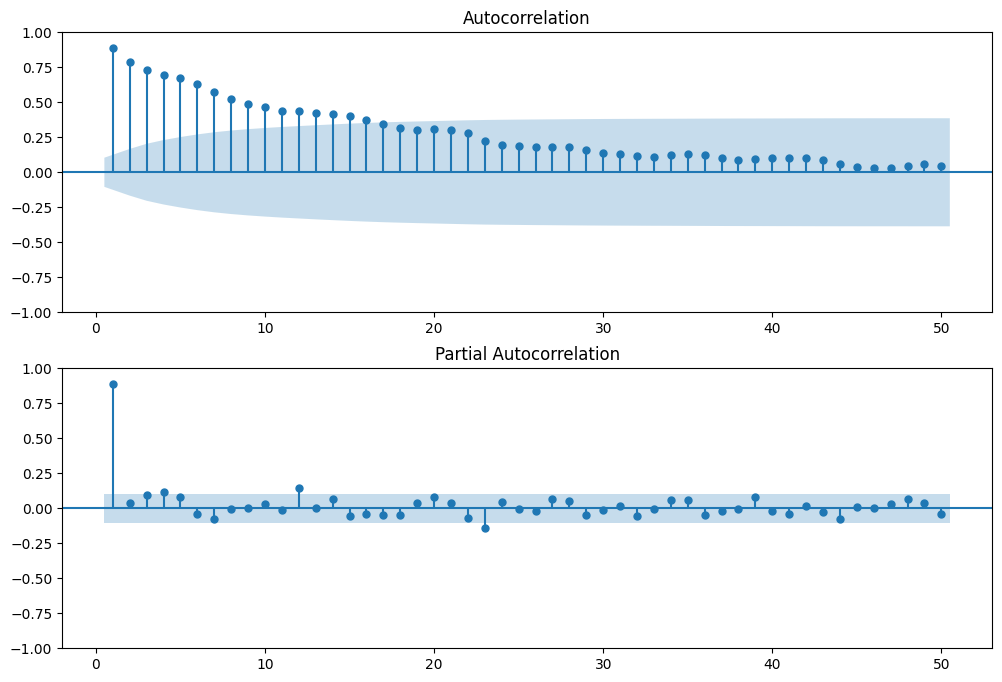

In [128]:
# Define the size of the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(daily_gas_price_df['gas_price'], lags=50, zero=False, ax=ax2)

# Show the plots
plt.show()